# Calculate $w_p$



In [102]:
# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('input_file')
#     parser.add_argument('header_file')
#     parser.add_argument('output_file')
#     parser.add_argument('pimax')
#     parser.add_argument('rp_min')
#     parser.add_argument('rp_max')
#     parser.add_argument('nbins')
#     args = parser.parse_args()

In [6]:
shuffle = True

In [7]:
import os.path
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

In [9]:
import seaborn as sns
sns.__version__

'0.11.2'

In [10]:
sns.set_style("dark")
sns.set_style("ticks")
sns.set(rc = {'figure.figsize':(15,8)})

In [11]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
infile_path = os.path.join(project_path,"data/results.npz")

In [129]:
infile = np.load(infile_path) 

# Calculate $w_p$ from $\xi$

$\begin{equation}
w_{p, A B}\left(r_{p}\right)=2 \int_{0}^{\Pi_{\max }} \xi_{A B}(r, \pi) d \pi
\end{equation}$

In [130]:
#Script passed on from A. Salcedo
import numpy as np
import scipy.integrate as integrate

def wp(rp,binmin,binmax,xi,pimax=None):
    """compute wp(r_p) from tabulated xi(r)."""
    
    lower_bound = rp 
    upper_bound = np.sqrt(rp**2 + pimax**2)
    binmask = np.logical_and(binmax > lower_bound, binmin < upper_bound)
    masked_xi = xi[binmask]
    r_i = binmin[binmask]
    r_iplus = binmax[binmask]
    s_plus = np.minimum(upper_bound, r_iplus)
    s_minus = np.maximum(lower_bound, r_i)
    # here we assume that xi is piecewise constant over the tabulated input bins
    elementwise_integral = 2.0*masked_xi * \
                           (np.sqrt(s_plus**2 - rp**2) - np.sqrt(s_minus**2 - rp**2))
    w_p = np.sum(elementwise_integral)

    return w_p

# Calcualte $\Delta \Sigma $ from $ w_p$ 

$\begin{equation}
\Delta \Sigma\left(r_{p}\right)=\Omega_{m} \rho_{\text {crit }}\left[\frac{2}{r_{p}^{2}} \int_{0}^{r_{p}} r^{\prime} w_{p, c m}\left(r^{\prime}\right) d r^{\prime}-w_{p, c m}\left(r_{p}\right)\right]
\end{equation}$

In [131]:
def DeltaSigma(binmin,binmax,xi,pimax=None,mean_rho=None,H0=None, rp_min=None, rp_max=None, nbins=None):
    # mean rho (in comoving Msun pc^-2, no little h)
    h = H0/100.

    # compute rp bins
    #nbins = 40
    #rp_min = 0.1
    #rp_max = 125.0
    rp_bins = np.logspace(np.log10(rp_min), np.log10(rp_max), nbins+1)
    rp_binmin = rp_bins[0:-1]
    rp_binmax = rp_bins[1:]
    rp_mid = (rp_binmin + rp_binmax)/2.0

    ds = np.zeros(rp_mid.shape[0])
    integrand = lambda r: r*wp(r,binmin,binmax,xi,pimax=pimax)
    for i in range(rp_mid.shape[0]):
        integral, abserr = integrate.quad(integrand, 0., rp_mid[i], epsabs=1.0e-2, epsrel=1.0e-2)
        ds[i] = (integral * (2.0/rp_mid[i]**2) - wp(rp_mid[i],binmin,binmax,xi,pimax=pimax)) * mean_rho

    # convert Mpc/h unit to pc (no h)
    #ds *= 1.0e6 / h
    ds *= 1.0e6 / h**2.0 #delta sigma comes out in Msun h / pc^2 units
    return rp_binmin, rp_binmax, ds

In [132]:
h = 0.6726

In [133]:
def DeltaSigma_from_files(header_file,filename,output_file,pimax,rp_min,rp_max,nbins):
    # read in cosmological parameters from header_file
    # import config
    # cf = config.AbacusConfigFile(header_file)
    # omega_m = cf.Omega_M # at z=0
    # H_0 = cf.H0
    
    H_0 = 67.26
    omega_m = 0.31415
    
    # compute mean_rho (comoving density units = Msun pc^-3)
    speed_of_light_km_s = 2.998e5 # km/s
    csq_over_G = 2.494e12 # 3c^2/(8*pi*G) Msun pc^-1
    
    mean_rho = omega_m * csq_over_G * (H_0/speed_of_light_km_s)**2 / 1.0e12 # Msun pc^-3
    
    print(filename)
    
    binmin,binmax,xi = np.loadtxt(filename,unpack=True)
    print(np.mean(xi))
    # print(binmin,binmax,xi)
    
    DS_binmin, DS_binmax, DS = DeltaSigma(binmin,binmax,xi,pimax=float(pimax),mean_rho=mean_rho,H0=H_0,rp_min=float(rp_min),rp_max=float(rp_max),nbins=int(nbins))
    np.savetxt(output_file, np.c_[DS_binmin, DS_binmax, np.zeros(DS.shape[0]), DS],
               delimiter='\t')
    return(np.array([DS_binmin,DS_binmax,DS]))

In [134]:
pimax = 100 #h^-1 Mpc
rp_min = 0.05
rp_max = 100
nbins = 20

In [135]:
modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]
headerfile=""
output_file = os.path.join(project_path,"data/DSigma.txt")

Delta_Sigma_array = [[None for _ in range(3)] for _ in range(4)]

for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    for j,mode in enumerate(modes):
        
        if shuffle == True:
            file_rel_path = f"data/shuffle_result_DD_{lambda_lower}_{mode}_d30.txt"
        else:
            file_rel_path = f"data/result_DD_{lambda_lower}_{mode}_d30.txt"
        
        filename_ = os.path.join(project_path,file_rel_path)
        print(filename_)
        assert os.path.exists(filename_)
        print(i-3,j)
        DSigma = DeltaSigma_from_files(headerfile,filename_,output_file,pimax,rp_min,rp_max,nbins)
        print(np.mean(DSigma[2]))
        Delta_Sigma_array[i-3][j]= DSigma

/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_all_d30.txt
0 0
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_all_d30.txt
1994.3333333333333
23.53597402227346
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_SPT_d30.txt
0 1
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_SPT_d30.txt
2044.6
24.542196268528617
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_nonSPT_d30.txt
0 2
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_20_nonSPT_d30.txt
1652.3
17.219804867148937
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_30_all_d30.txt
1 0
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_30_all_d30.txt
1864.4666666666667
22.518797119931595
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_30_SPT_d30.txt
1 1
/global/cfs/cdirs/des/zhou/spt_lensing/data/shuffle_result_DD_30_SPT_d30.txt
1920.6333333333334
23.895182399680635
/global/cfs/cdirs/des/zhou/spt_lensing/

In [136]:
for i in range(4):
    for j in range(3):
        print(np.mean(Delta_Sigma_array[i][j][2]))

23.53597402227346
24.542196268528617
17.219804867148937
22.518797119931595
23.895182399680635
19.06342389394101
26.183699818595574
26.201518188322503
20.549534123413398
20.16319197892752
20.21145606277726
20.086548204375426


In [137]:
for DSigma in np.array(Delta_Sigma_array):
    print(np.mean(DSigma[2]))

14.611700015348674
15.226239690946029
15.721609767436822
15.567281127757502


In [138]:
print(shuffle)
if shuffle == True:
    DSigma_rel_path = "data/DSigma_shuffle.npy"
else:
    DSigma_rel_path = "data/DSigma.npy"
np.save(os.path.join(project_path,DSigma_rel_path),Delta_Sigma_array)

True


In [139]:
# sns.set_style('ticks')

richness: 20,30
all
[-3.25960718e+01  4.42094282e+01  7.63354367e+01  9.02111582e+01
  7.34131184e+01  6.57450168e+01  4.85307123e+01  3.67135486e+01
  2.34814282e+01  1.53601420e+01  1.06915243e+01  6.63692288e+00
  4.62078043e+00  2.85189803e+00  2.42992308e+00  1.13534709e+00
  5.30589212e-01  2.47787389e-01  1.16460977e-01  5.43293701e-02]
richness: 20,30
SPT
[-3.44375212e+01  3.69541674e+01  7.88081901e+01  1.03026799e+02
  7.63756595e+01  6.76793320e+01  5.06707438e+01  3.80838681e+01
  2.47262490e+01  1.59877417e+01  1.15116450e+01  7.56744209e+00
  4.83040381e+00  3.46686253e+00  3.00979800e+00  1.40691314e+00
  6.57816872e-01  3.06662856e-01  1.43852082e-01  6.72992337e-02]
richness: 20,30
nonSPT
[-2.11897247e+01  5.42210717e+01  6.58646695e+01  6.90365294e+01
  5.39022660e+01  4.33200886e+01  2.83934656e+01  1.98108969e+01
  1.17110534e+01  7.28641640e+00  4.50850737e+00  2.77072479e+00
  2.12062107e+00  1.41155803e+00  6.61017673e-01  3.08422464e-01
  1.44412551e-01  6.74488

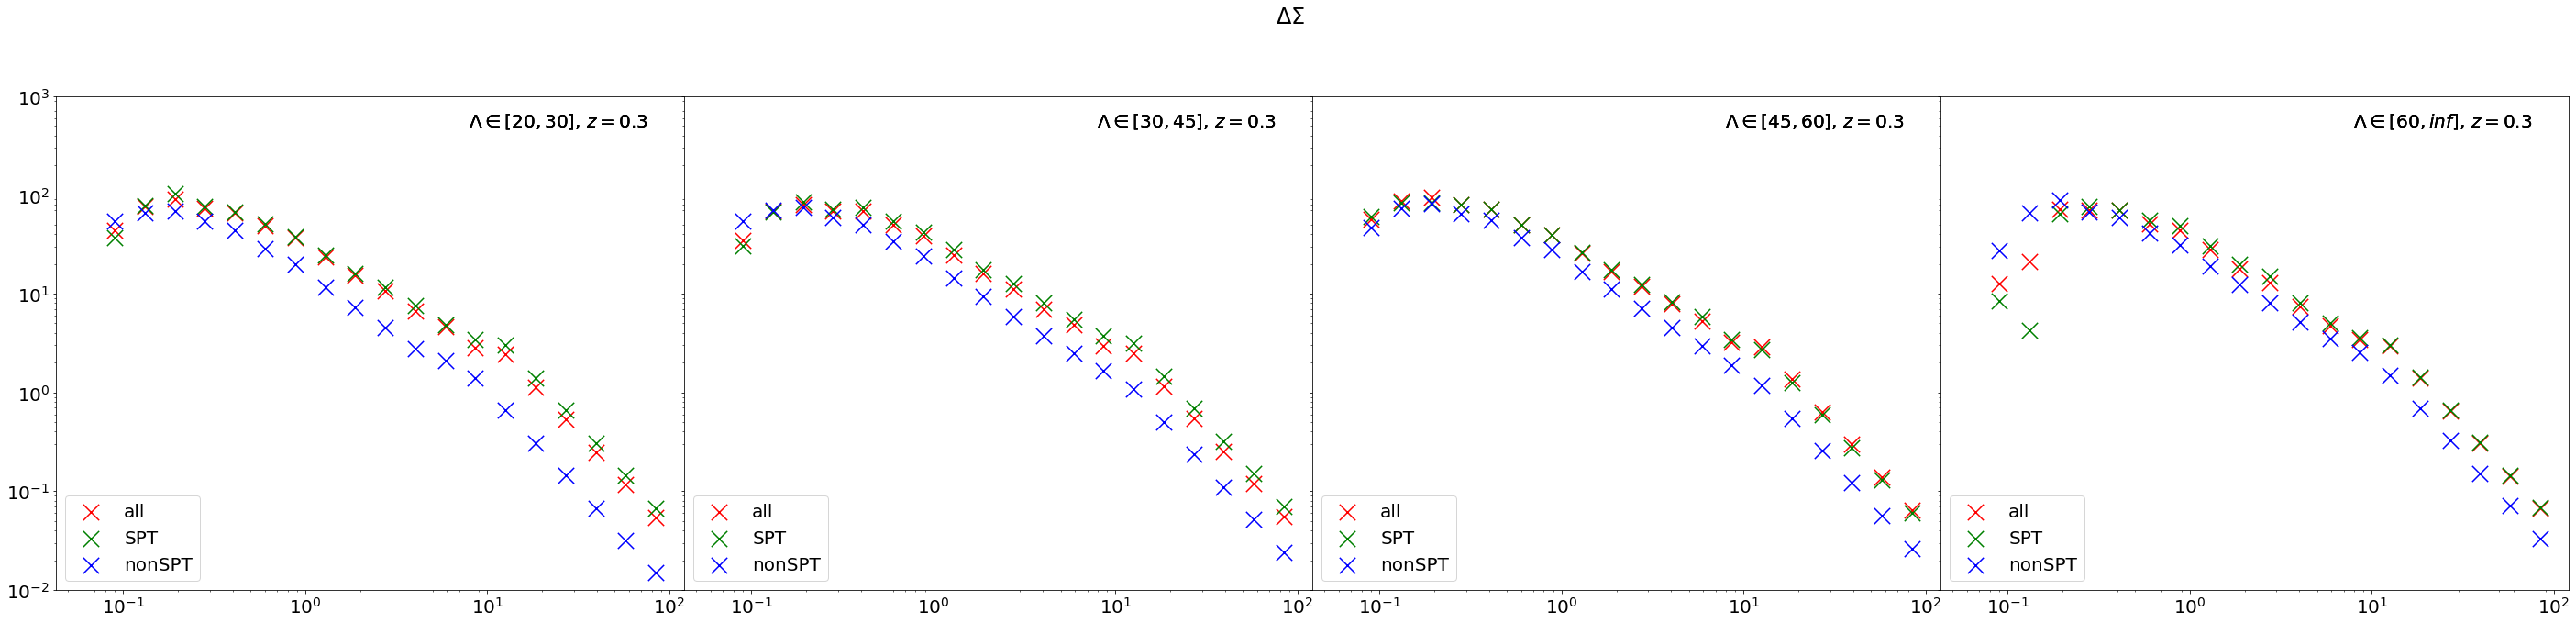

In [140]:
fig,axes = plt.subplots(ncols=4, figsize = [40,10],sharey=True)

modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]

plt.rcParams.update({'font.size':20})


for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    for j,mode in enumerate(modes):
        ax = axes[i-3]
        ax.text(0.80, 0.95, rf'$\Lambda \in [{lambda_lower},{lambda_upper}]$, $z=0.3$', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        # print(i-3,j)
        DSigma = Delta_Sigma_array[i-3][j]
        print(f"richness: {lambda_lower},{lambda_upper}")
        print(mode)
        print(DSigma[2])
        # plot1 = sns.lineplot(x=0.5*(DSigma[0]+DSigma[1]),y=DSigma[2],label=mode,ax=axes[i-3],legend=False)
        if mode == "all":
            color_= "r"
        elif mode == "SPT":
            color_ = "g"
        elif mode == "nonSPT":
            color_ = "b"
        ax.scatter(x=0.5*(DSigma[0]+DSigma[1]),y=DSigma[2],label=mode,marker="x",
                  c=color_, s=300)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.01,1E3)
        # print(np.mean(DSigma[2]))
        # plot1.set(xscale="log",yscale="log",ylim=(0.01,1000))
        # plot2.set(xscale="log",yscale="log",ylim=(0.01,1E3))
        # plot2.legend(loc="lower left")
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.legend(loc="lower left",prop={'size':20})
    
# fig.get_axes()[0].annotate(r'$\Delta \Sigma$', (0.5, 0.95), 
#                             xycoords='figure fraction', ha='center', 
#                             fontsize=15
#                             )

fig.suptitle(r"$\Delta \Sigma$")
fig.tight_layout(pad=2)

plt.subplots_adjust(wspace=0)

In [141]:
    shuffle_DSigma_rel_path = "data/DSigma_shuffle.npz"
    normal_DSigma_rel_path = "data/DSigma.npz"
np.save(os.path.join(project_path,DSigma_rel_path),Delta_Sigma_array)